## Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing the datasets

In [4]:

travel_time_451_df = pd.read_csv('/content/TravelTime_387.csv')
travel_time_387_df = pd.read_csv('/content/TravelTime_451.csv')
# Parse the timestamp to datetime objects
travel_time_451_df['timestamp'] = pd.to_datetime(travel_time_451_df['timestamp'])
travel_time_387_df['timestamp'] = pd.to_datetime(travel_time_387_df['timestamp'])

# Set the timestamp as the index
#travel_time_451_df.set_index('timestamp', inplace=True)
#travel_time_387_df.set_index('timestamp', inplace=True)

In [5]:
travel_time_387_df.head(5)

,timestamp,value
0,2015-07-28 11:56:00,248
1,2015-07-28 12:06:00,178
2,2015-07-28 12:25:00,155
3,2015-07-28 13:56:00,121
4,2015-07-28 14:06:00,103


In [6]:
travel_time_451_df.head()

,timestamp,value
0,2015-07-10 14:24:00,564
1,2015-07-10 14:38:00,730
2,2015-07-10 14:48:00,770
3,2015-07-10 15:03:00,910
4,2015-07-10 15:22:00,1035


# Functions

In [14]:
def calculate_nonconformity_scores(data):
    """
    Calculate nonconformity scores based on absolute deviation from the median.

    Parameters:
    - data: array-like, the data points.

    Returns:
    - nonconformity_scores: array-like, nonconformity scores for each data point.
    """
    n = len(data)
    nonconformity_scores = np.zeros(n)

    for t in range(1, n):
        # Compute the median of all previous observations
        median = np.median(data[:t])
        # Calculate nonconformity score as absolute deviation from the median
        nonconformity_scores[t] = abs(data[t] - median)

    return nonconformity_scores

def calculate_p_values(nonconformity_scores):
    """
    Calculate p-values for each data point based on nonconformity scores.

    Parameters:
    - nonconformity_scores: array-like, nonconformity scores of the data points.

    Returns:
    - p_values: array-like, p-values for each data point.
    """
    n = len(nonconformity_scores)
    p_values = np.zeros(n)

    for t in range(1, n):
        # Count how many previous scores are greater than or equal to the current score
        count_greater = np.sum(nonconformity_scores[:t] >= nonconformity_scores[t])
        # Compute the p-value
        p_values[t] = (count_greater + 1) / (t + 1)

    return p_values

def conformal_testing_martingale(data, epsilon=0.05):
    """
    Conformal Testing Martingale for change point detection using logarithmic scale.

    Parameters:
    - data: array-like, the data to analyze.
    - epsilon: float, the significance level for betting strategy.

    Returns:
    - martingale: array-like, the computed martingale values.
    - p_values: array-like, the p-values for each point.
    """
    nonconformity_scores = calculate_nonconformity_scores(data)
    p_values = calculate_p_values(nonconformity_scores)

    n = len(data)
    log_martingale = np.zeros(n)  # Start log martingale with 0

    for t in range(1, n):
        if p_values[t] > 0:
            # Correct betting function: epsilon * p_value^(epsilon - 1)
            betting_fraction = epsilon * (p_values[t] ** (epsilon - 1))
            log_martingale[t] = log_martingale[t-1] + np.log(betting_fraction)
        else:
            # Handle zero p-value case to avoid division by zero
            log_martingale[t] = log_martingale[t-1]  # No update if p_value is zero

    # Convert log martingale back to normal scale and avoid overflow
    martingale = np.exp(log_martingale - np.max(log_martingale))  # Normalize to prevent overflow

    return martingale, p_values

def plot_results(data, martingale, threshold, title):
    """
    Plot the data, martingale values, and detected change points.

    Parameters:
    - data: array-like, the original data values.
    - martingale: array-like, the computed martingale values.
    - threshold: float, threshold for detecting change points.
    - title: str, the title for the plot.
    """
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot the data
    ax1.plot(data, label='Data', color='b')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Data Values', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    # Add a secondary y-axis for the martingale values
    ax2 = ax1.twinx()

    # Normalize and rescale martingale for better visualization
    martingale_normalized = np.exp(martingale - np.max(martingale))
    martingale_rescaled = martingale_normalized * (max(data) / 2)

    ax2.plot(martingale_rescaled, label='Martingale (Rescaled)', linestyle='--', color='r')
    ax2.set_ylabel('Martingale Values (Rescaled)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add a threshold line for detecting significant change points
    ax2.axhline(y=threshold * (max(data) / 2), color='g', linestyle='-.', label='Threshold')

    # Annotate detected change points
    change_points = np.where(martingale_rescaled > threshold * (max(data) / 2))[0]
    for cp in change_points:
        ax1.axvline(x=cp, color='purple', linestyle=':', alpha=0.5)
        ax1.text(cp, data[cp], f'CP {cp}', fontsize=8, rotation=90, verticalalignment='bottom')

    # Add a legend
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
    plt.title(title)
    plt.show()


# Extracting values from the datasets

In [12]:
travel_time_451_values = travel_time_451_df['value'].values
travel_time_387_values = travel_time_387_df['value'].values
# Apply the conformal testing martingale algorithm to both datasets
martingale_451, p_values_451 = conformal_testing_martingale(travel_time_451_values)
martingale_387, p_values_387 = conformal_testing_martingale(travel_time_387_values)
# Define a threshold for martingale to detect change points
martingale_threshold = 0.4



# Plot results for the 'Travel Time 451' dataset

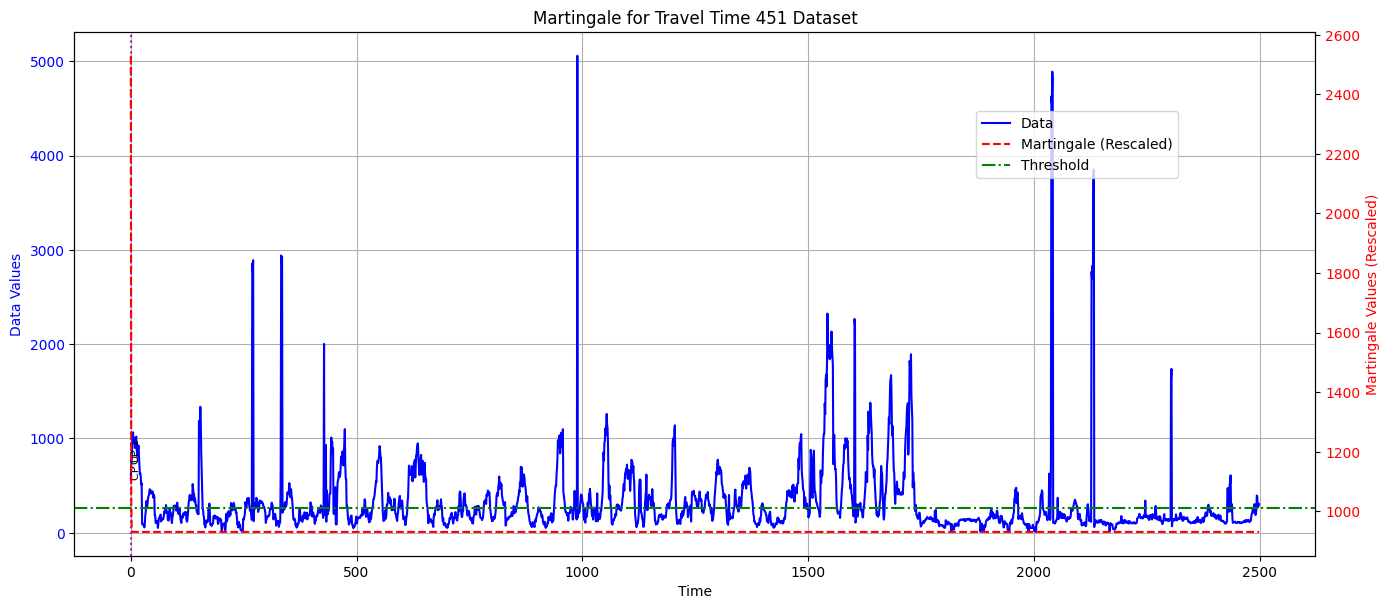

In [15]:
plot_results(travel_time_451_values,martingale_451, martingale_threshold, 'Martingale for Travel Time 451 Dataset')


# Plot results for the 'Travel Time 387' dataset

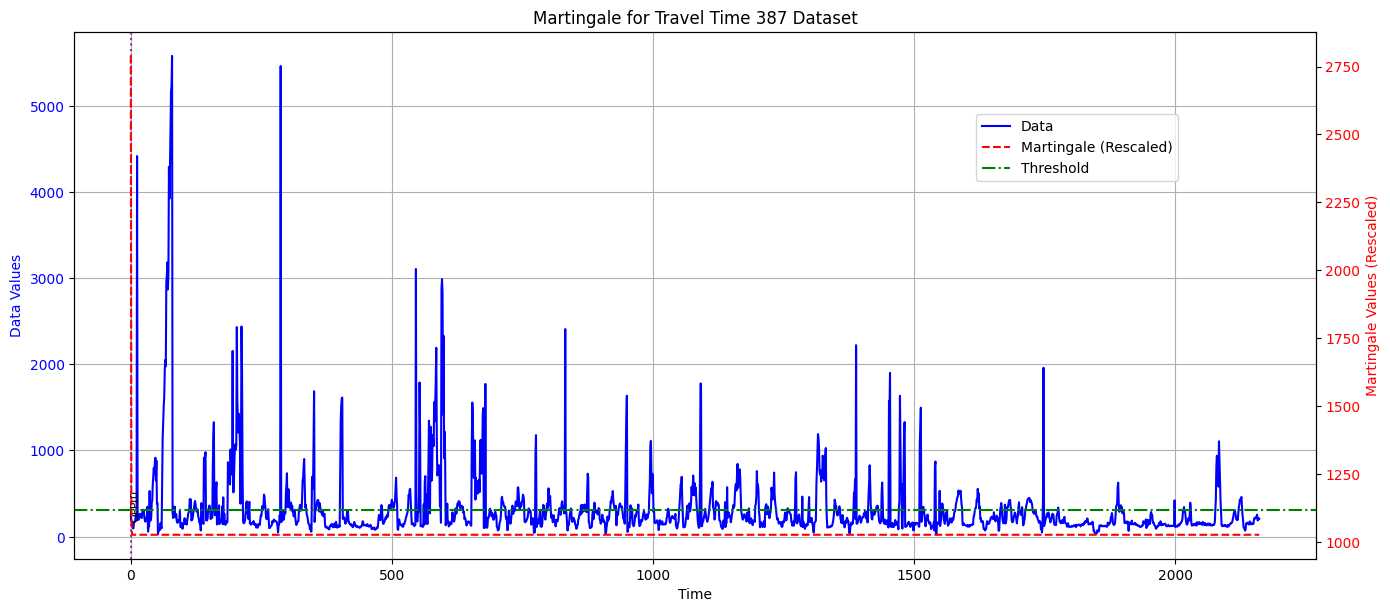

In [16]:
plot_results(travel_time_387_values, martingale_387, martingale_threshold, 'Martingale for Travel Time 387 Dataset')